In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from arch.unitroot import ADF
from statsmodels.tsa.api import VAR
from statsmodels.tsa.vector_ar.vecm import VECM, coint_johansen
import yfinance as yf

In [4]:
def get_forex_data_yahoo(symbol, start, end):
    df = yf.download(symbol, start=start, end=end, interval='1mo')
    df = df[['Close']].rename(columns={'Close': f'{symbol}_close'})
    return df

start_date = '2014-01-01'
end_date = '2024-01-01'

eur_usd = get_forex_data_yahoo('EURUSD=X', start=start_date, end=end_date)
gbp_usd = get_forex_data_yahoo('GBPUSD=X', start=start_date, end=end_date)
aud_usd = get_forex_data_yahoo('AUDUSD=X', start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [5]:
forex_data = pd.concat([eur_usd, gbp_usd, aud_usd], axis=1).dropna()
forex_data.head()

,EURUSD=X_close,GBPUSD=X_close,AUDUSD=X_close
Date,,,
2014-01-01,1.355877,1.649838,0.879585
2014-02-01,1.370746,1.669198,0.896170
2014-03-01,1.375213,1.664392,0.926012
2014-04-01,1.381368,1.682425,0.927472
2014-05-01,1.363457,1.675912,0.930925


In [6]:
forex_data.shape

(120, 3)

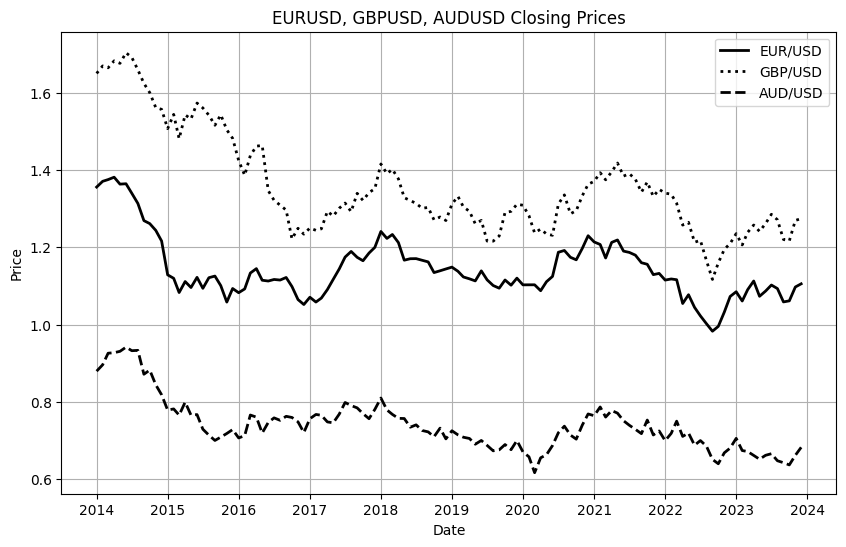

In [7]:
plt.figure(figsize=(10, 6))

plt.plot(forex_data['EURUSD=X_close'], label='EUR/USD', color='black', linestyle='-', linewidth=2)
plt.plot(forex_data['GBPUSD=X_close'], label='GBP/USD', color='black', linestyle=':', linewidth=2)
plt.plot(forex_data['AUDUSD=X_close'], label='AUD/USD', color='black', linestyle='--', linewidth=2)

plt.title('EURUSD, GBPUSD, AUDUSD Closing Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()

plt.savefig('forex2.png')
plt.show()

In [8]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series, column_name):
    result = adfuller(series)
    print(f'ADF statistics for {column_name}: {result[0]}')
    print(f'p-value for {column_name}: {result[1]}')
    for key, value in result[4].items():
        print(f'Critical Value {key}: {value}')
    if result[1] <= 0.05:
        print(f"{column_name} is stationary")
        print('')
        return True
    else:
        print(f"{column_name} is not stationary")
        print('')
        return False
    print('')

def make_stationary(df):
    stationary_df = pd.DataFrame()
    for column in df.columns:
        series = df[column]
        is_stationary = adf_test(series, column)
        differencing_count = 0
        while not is_stationary:
            series = series.diff().dropna()
            differencing_count += 1
            is_stationary = adf_test(series, column)
            if differencing_count > 2: 
                break
        stationary_df[column] = series
    return stationary_df

stationary_df = make_stationary(forex_data)

ADF statistics for EURUSD=X_close: -2.7574274372930323
p-value for EURUSD=X_close: 0.06461697357723188
Critical Value 1%: -3.4865346059036564
Critical Value 5%: -2.8861509858476264
Critical Value 10%: -2.579896092790057
EURUSD=X_close is not stationary

ADF statistics for EURUSD=X_close: -9.912439143176142
p-value for EURUSD=X_close: 3.143065464494437e-17
Critical Value 1%: -3.4870216863700767
Critical Value 5%: -2.8863625166643136
Critical Value 10%: -2.580009026141913
EURUSD=X_close is stationary

ADF statistics for GBPUSD=X_close: -2.1917507025079708
p-value for GBPUSD=X_close: 0.20925308812589433
Critical Value 1%: -3.4865346059036564
Critical Value 5%: -2.8861509858476264
Critical Value 10%: -2.579896092790057
GBPUSD=X_close is not stationary

ADF statistics for GBPUSD=X_close: -11.221577160818862
p-value for GBPUSD=X_close: 2.0074103825571442e-20
Critical Value 1%: -3.4870216863700767
Critical Value 5%: -2.8863625166643136
Critical Value 10%: -2.580009026141913
GBPUSD=X_close is 

In [9]:
from statsmodels.tsa.vector_ar.vecm import select_order

model = VAR(forex_data)
x = model.select_order(maxlags=15, trend="c")
print(x.summary())

optimal_lag_aic = x.aic
print(f"Optimal lag length based on AIC: {optimal_lag_aic}")

optimal_lag_bic = x.bic
print(f"Optimal lag length based on BIC: {optimal_lag_bic}")

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -17.71      -17.63   2.037e-08      -17.68
1      -23.04*     -22.73*  9.879e-11*     -22.92*
2       -22.92      -22.39   1.112e-10      -22.71
3       -22.81      -22.05   1.240e-10      -22.50
4       -22.73      -21.75   1.345e-10      -22.33
5       -22.73      -21.52   1.347e-10      -22.24
6       -22.66      -21.21   1.466e-10      -22.07
7       -22.67      -21.00   1.453e-10      -22.00
8       -22.60      -20.70   1.580e-10      -21.83
9       -22.47      -20.35   1.806e-10      -21.61
10      -22.41      -20.06   1.953e-10      -21.46
11      -22.40      -19.82   2.009e-10      -21.36
12      -22.34      -19.53   2.184e-10      -21.20
13      -22.31      -19.27   2.319e-10      -21.08
14      -22.26      -19.00   2.512e-10      -20.94
15      -22.18      -18.70   2.809e-10      -20.77
-------------------------------

C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [10]:
from statsmodels.tsa.stattools import adfuller

adf_test = adfuller(forex_data['EURUSD=X_close'])
print(f'ADF Statistic (without trend): {adf_test[0]}, p-value: {adf_test[1]}')

adf_test_trend = adfuller(forex_data['EURUSD=X_close'], regression='ct')  # 'ct' includes constant and trend
print(f'ADF Statistic (with trend): {adf_test_trend[0]}, p-value: {adf_test_trend[1]}')


ADF Statistic (without trend): -2.7574274372930323, p-value: 0.06461697357723188
ADF Statistic (with trend): -2.474913295478092, p-value: 0.340616106434666


In [11]:
import pandas as pd
from statsmodels.tsa.vector_ar.vecm import coint_johansen

jtest = coint_johansen(forex_data, det_order=0, k_ar_diff=1)

print(f"Eigenvalues of VECM coefficient matrix : {jtest.eig}\n")

trace_test_results = pd.DataFrame(
    {
        "Test statistic": jtest.trace_stat,
        "Critical values (90%)": jtest.trace_stat_crit_vals[:, 0],
        "Critical values (95%)": jtest.trace_stat_crit_vals[:, 1],
        "Critical values (99%)": jtest.trace_stat_crit_vals[:, 2],
    },
    index=["rank=0", "rank<=1", "rank<=2"]
)
print(trace_test_results)


Eigenvalues of VECM coefficient matrix : [0.09713965 0.06325893 0.05385824]

         Test statistic  Critical values (90%)  Critical values (95%)  \
rank=0        26.302038                27.0669                29.7961   
rank<=1       14.243927                13.4294                15.4943   
rank<=2        6.532818                 2.7055                 3.8415   

         Critical values (99%)  
rank=0                 35.4628  
rank<=1                19.9349  
rank<=2                 6.6349  


In [12]:
vecm_model = VECM(endog=forex_data, k_ar_diff=1, deterministic="ci").fit()
print(vecm_model.summary())

Det. terms outside the coint. relation & lagged endog. parameters for equation EURUSD=X_close
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
L1.EURUSD=X_close     0.2174      0.126      1.724      0.085      -0.030       0.465
L1.GBPUSD=X_close    -0.0676      0.085     -0.793      0.428      -0.235       0.099
L1.AUDUSD=X_close    -0.0894      0.126     -0.707      0.480      -0.337       0.158
Det. terms outside the coint. relation & lagged endog. parameters for equation GBPUSD=X_close
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
L1.EURUSD=X_close     0.2503      0.177      1.412      0.158      -0.097       0.598
L1.GBPUSD=X_close    -0.0872      0.120     -0.728      0.467      -0.322       0.148
L1.AUDUSD=X_close    -0.1345      0.17

C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


The cointegration equation is given by:

$S = \text{constant} + \beta_1 \times \text{(EUR/USD)} + \beta_2 \times \text{(GBP/USD)}$


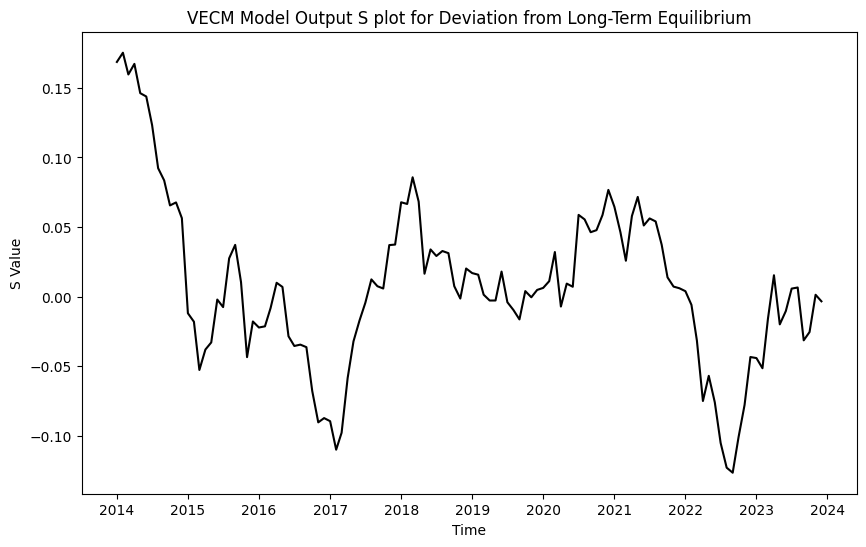

In [13]:
S = (
    vecm_model.const_coint[0][0]
    + vecm_model.beta[0][0] * forex_data['EURUSD=X_close']
    + vecm_model.beta[1][0] * forex_data['GBPUSD=X_close']
    + vecm_model.beta[2][0] * forex_data['AUDUSD=X_close']
)

plt.figure(figsize=(10, 6)) 
plt.plot(S, color='black') 
plt.title('VECM Model Output S plot for Deviation from Long-Term Equilibrium')
plt.xlabel('Time')
plt.ylabel('S Value')
plt.savefig('VECM2.png')
plt.show()

In [14]:
S

Date
2014-01-01    0.168522
2014-02-01    0.175156
2014-03-01    0.159547
2014-04-01    0.167144
2014-05-01    0.146119
                ...   
2023-08-01    0.006581
2023-09-01   -0.031355
2023-10-01   -0.025396
2023-11-01    0.001357
2023-12-01   -0.003341
Length: 120, dtype: float64

In [15]:
S_adf = ADF(S, trend="n", method="bic")
print("Augmented Dickey-Fuller Unit Root Test\n", S_adf.regression.summary())
print("\nTest statistics and critical values: \n", S_adf)

Augmented Dickey-Fuller Unit Root Test
                                  OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.073
Model:                            OLS   Adj. R-squared (uncentered):              0.065
Method:                 Least Squares   F-statistic:                              9.253
Date:                Thu, 26 Sep 2024   Prob (F-statistic):                     0.00290
Time:                        11:51:55   Log-Likelihood:                          295.30
No. Observations:                 119   AIC:                                     -588.6
Df Residuals:                     118   BIC:                                     -585.8
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-

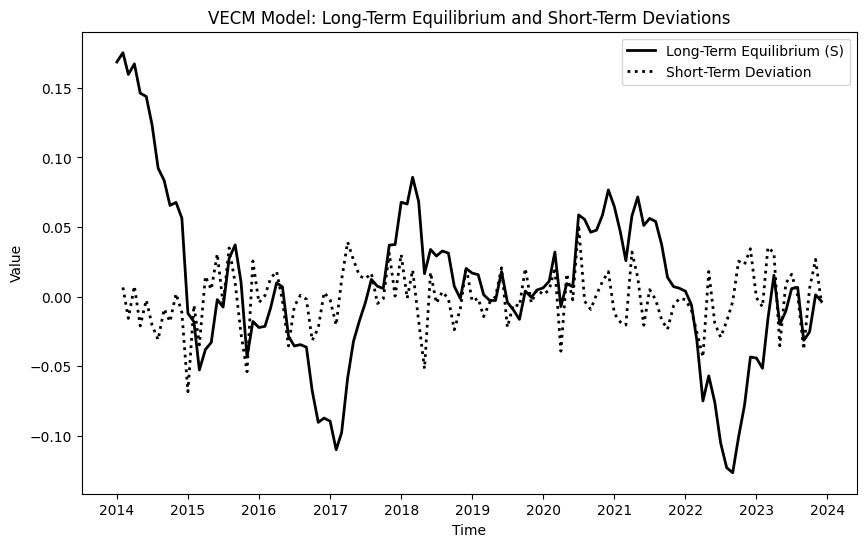

In [16]:
delta_eur_usd = forex_data['EURUSD=X_close'].diff().dropna()
delta_gbp_usd = forex_data['GBPUSD=X_close'].diff().dropna()
delta_aud_usd = forex_data['AUDUSD=X_close'].diff().dropna()

short_term_deviation = (
    vecm_model.beta[0][0] * delta_eur_usd 
    + vecm_model.beta[1][0] * delta_gbp_usd
    + vecm_model.beta[2][0] * delta_aud_usd
).dropna()

plt.figure(figsize=(10, 6)) 

plt.plot(S, color='black', label='Long-Term Equilibrium (S)', linewidth=2)

plt.plot(short_term_deviation, color='black', label='Short-Term Deviation', linestyle=':', linewidth=2)
plt.title('VECM Model: Long-Term Equilibrium and Short-Term Deviations')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(loc='best')
plt.savefig('VECM3.png')
plt.show()


In [17]:
correlation_matrix = stationary_df.corr(method='pearson')  # Use 'spearman' or 'kendall' for other methods
print(correlation_matrix)

                EURUSD=X_close  GBPUSD=X_close  AUDUSD=X_close
EURUSD=X_close        1.000000        0.624280        0.616327
GBPUSD=X_close        0.624280        1.000000        0.503762
AUDUSD=X_close        0.616327        0.503762        1.000000


In [19]:
import grangercausalitytests

max_lag = 1

currency_pairs = ['EURUSD=X_close', 'GBPUSD=X_close', 'AUDUSD=X_close']
results = {}

for i, currency1 in enumerate(currency_pairs):
    for j, currency2 in enumerate(currency_pairs):
        if i != j:
            test_result = grangercausalitytests(stationary_df[[currency1, currency2]], max_lag, verbose=False)
            results[f"{currency1} causes {currency2}"] = test_result[max_lag][0]['ssr_ftest'][1]

print("\nGranger Causality Test Results with Optimal Lag:")
for cause_effect, p_value in results.items():
    print(f"{cause_effect}: p-value = {p_value:.4f}")

ModuleNotFoundError: No module named 'grangercausalitytests'